# Bucket Pricing

The main idea is to clean the distributions of the categories included in the data (each CategoryDesc and Manufacturer will be considered as a different category), to create groups of similar categories using clustering for **Mexico**

The features for the **clustering** will be some statistical metrics like:

    - Mode
    - Standard Deviation
    - Variance
    - Kurtosis
    - Skewness
    - Max/Min
    - Average
    - Different Quantiles
    - Distance between Average and Median, Max, Min, and different quantiles
    - Etc

Then, having groups of similar categories, create buckets for the ones that has not too much variance.

The data will have filters, given by Michael Keim's team

- Sales from June 2020 to December 2020
- Min sold price of $5
- Exclude 271+
- All item conditions
- LTV filter >= 20% and <=80%
- 20 or more transactions (we will need evaluate further based on the addition of all item conditions) 
- Exclude items discounted by 25% or more (Total Discount)
- Exclude manufacturers that are beneath 80% of the category composition
- In an effort to remove erroneous manufacturer names/bad data
- Don’t group categories
- Categories that use attributes can we use the KS method to find similarities in distributions - and if they can be grouped?
- Use IQR Fences
- 20 or more transactions that meet the above criteria


#  Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(forcats)
library(readr)
library(factoextra)
library(psych)
library(moments) 
library(FactoMineR)
library(dbscan)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




# Read Data

In [2]:
data <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_Jun20Dec20_MX.csv')
data %>%
 filter(item_cond == 'B') -> data

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  sold_price = col_double(),
  tax = col_double(),
  Item_ezid = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  store = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.

Warning message:
“9780 parsing failures.
 row  col expected actual                                                                                file
6082 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_Jun20Dec20_MX.csv'
6105 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_Jun20Dec20_MX.csv'
7808 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_Jun20Dec20_MX.csv'
7809 cost a double   NULL '/Users/darias/Documents/Bucket_Pricing/Data/bucket_pricing_data_Jun20Dec20_MX.csv'
7810

In [3]:
data$date <- substr(data$origindate,1,10) %>% as.Date


Example of 1 row of the data

In [4]:
head(data,1) %>% t


[,1]                     
Country             MEX                      
primary_relation    424159846                
gid                 29799018                 
origindate          2020-06-02 17:28:42 +0000
FiscalYear          2020                     
original_price      1399                     
sold_price          699                      
tax                 96.41                    
Item_ezid           855201193093             
ItemID              507153890                
cost                705                      
item_categorization 573002                   
Primary             General Merchandise      
Secondary           Household/Office Goods   
Tertiary            Telephone                
CategoryDesc        Cellular Telephone       
item_type           GM                       
store               85520                    
transType           Sales                    
customerType        Customer                 
Inventory_Days      185                      
Manufacturer        ALCATEL                  
Model_Number        1C                       
item_cond           B                        
date                2020-06-02

Manufacturer in lowercase, without spaces

In [5]:
data %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Manufacturer = gsub(' ', '', Manufacturer)) -> data


In [6]:
f0 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


# Cleaning  Data

## Drop big categories

The business wants buckets for "other stuff", so it will be dropped categories like:
 - TVs
 - Videogames
 - Tablets
 - Cellphones
 - Laptop

In [7]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'null',
'Shoes',
'NULL',
'')


In [8]:
data %>%
 filter(!(CategoryDesc %in% x)) -> data


Drop Manufacturer in NULL

In [9]:
data %>%
 filter(Manufacturer != 'null', !is.na(Manufacturer),
        CategoryDesc != 'null', !is.na(CategoryDesc)) -> data


In [10]:
f1 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


## June 2020 and forward

In [11]:
data %>%
 filter(date >= as.Date('2020-06-01'),date <= as.Date('2020-12-31')) -> data


In [12]:
f2 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


## Sold price >  50 MXN

For the business, every item sold <= 5 dlls has no importance, so will be filtered

In [13]:
data %>%
 filter(sold_price >= 50) -> data


In [14]:
f3 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


## Sold in first 271 days

In [15]:
data %>%
 filter(Inventory_Days <= 271) -> data


In [16]:
f4 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


## LTV filter

Just items with LTV between 20% and 80%

In [17]:
data %>%
 mutate(LTV = cost/sold_price) %>%
 filter(LTV >= 0.2, LTV <= 0.8) -> data


In [18]:
f5 <- c(nrow(data),length(unique(paste0(data$CategoryDesc,data$Manufacturer))))


## Create Category

Paste the Manufacturer and the CategoryDesc to create the Categories

In [19]:
data %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data


## Discount < 25%

In [20]:
options(warn=-1)
data %>%
 mutate(dct = 1 - (as.numeric(sold_price)/as.numeric(original_price))) %>%
 filter(dct < 0.25, !is.na(dct))  %>%
 select(-dct) -> data


In [21]:
f6 <- c(nrow(data),length(unique(data$CategoryDesc)))


## Drop outliers

Left and right outliers will be dropped, keeping values between Q15 and Q80

In [22]:
LimInf_fun <- function(x){
    a <- quantile(x,0.15)
    
    b <- a %>% as.numeric
    
    return(b)
}

In [23]:
LimSup_fun <- function(x){
    a <- quantile(x,0.80)
    
    b <- a %>% as.numeric
    
    return(b)
}

In [24]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(lim_inf = LimInf_fun(sold_price),
        lim_sup = LimSup_fun(sold_price)) %>%
 ungroup %>%
 filter(sold_price > lim_inf, sold_price < lim_sup) %>%
 select(-lim_inf, -lim_sup) -> data


In [25]:
f7 <- c(nrow(data),length(unique(data$CategoryDesc)))


## 20 items

To have reasonable distributions, only will be considered CategoryDesc with at least 20 items

In [26]:
data %>%
 group_by(CategoryDesc) %>%
 mutate(n = n()) %>%
 filter(n >= 20) %>%
 select(-n) -> data


In [27]:
f8 <- c(nrow(data),length(unique(data$CategoryDesc)))


# Waterfall

Plot with the number of rows and unique CategoryDesc and Manufacturer

In [28]:
data.frame(rbind(f0,f1,f2,f3,f4,f5,f6,f7,f8)) -> wf

names(wf) <- c('Rows','Distinct_CatMan')

desc <- c('No Filter',
          'Drop big categories',
          'June20-Dec20',
          'Sold Price >= $5',
          'Sold first 271 days',
          'LTV Filter',
          'Discount <= 25%',
          'Drop Outliers',
          '20 items')

wf$desc <- desc
wf$desc <- fct_inorder(wf$desc)


## Total rows

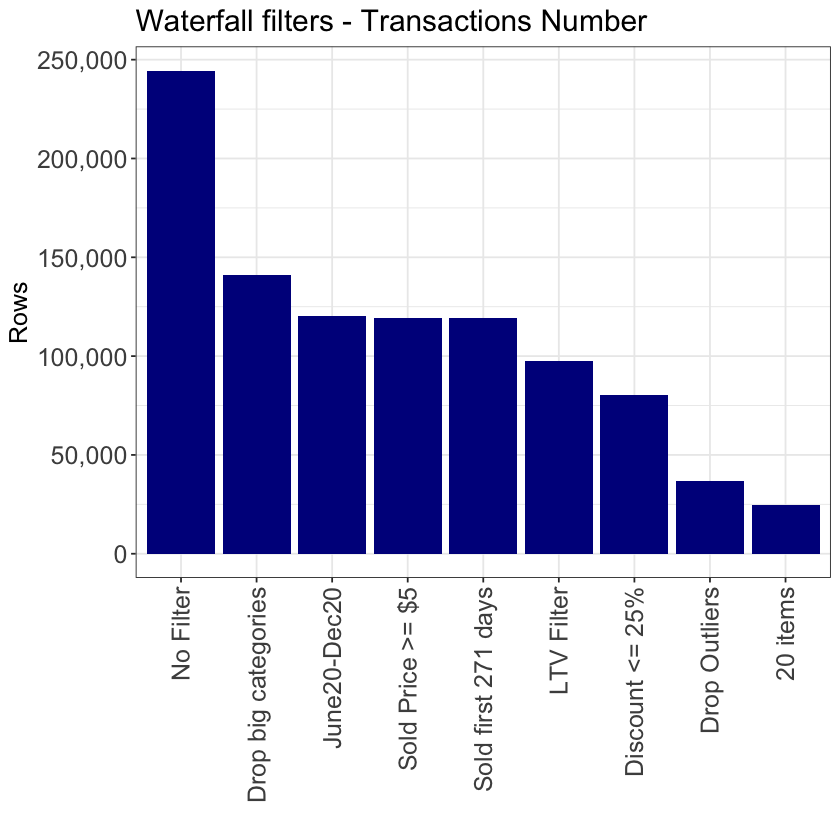

In [29]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Rows), fill = 'darkblue') +
 ggtitle('Waterfall filters - Transactions Number') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma)


## Unique Manufacturer-CategoryDesc

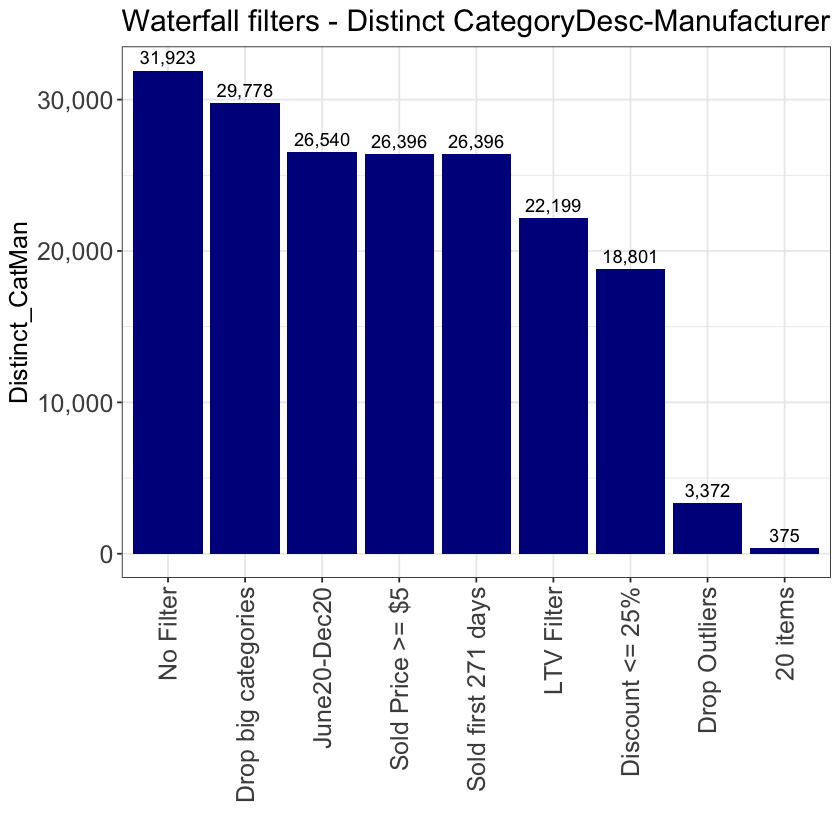

In [30]:
wf %>%
 ggplot() +
 geom_col(aes(x = desc, y = Distinct_CatMan), fill = 'darkblue') +
 ggtitle('Waterfall filters - Distinct CategoryDesc-Manufacturer') +
 theme_bw() +
 xlab('') +
 theme(axis.text.x  = element_text(size = 15, angle = 90, hjust = 1, vjust = 0.5),
       axis.text.y  = element_text(size = 15),
       axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       title        = element_text(size = 15),
       legend.position = 'none') +
 scale_y_continuous(labels = scales::comma) +
 geom_text(aes(x     = desc,
               y     = Distinct_CatMan, 
               label = scales::comma(Distinct_CatMan)), vjust = -0.5)


# Clustering

We will try to clusterize all the distributions for each **CategoryDesc/Manufacturer**, using some distributions metrics of the **sold price**

 - Mode 1
 - Mode 2
 - Mode 1 - Mode 2
 - Pct of cases for mode 1
 - Pct of cases for mode 2
 - Mean
 - Median
 - Standard Deviation
 - Min
 - Max
 - Q25
 - Q75
 - Q10
 - Q90
 - Mean/Standard Deviation
 - Mean - Median
 - Mean/median
 - Mean - Q25
 - Mean - Q75
 - Mean - Q10
 - Mean - Q90
 - Mean - Min
 - Mean - Max
 - Mean - Mode 1
 - Mean - Mode 2
 - Kurtosis
 - Skewness
 - Median - Q25
 - Median - Q75
 - Median - Q10
 - Median - Q90
 - Median - Min
 - Median - Max
 - Median - Mode 1
 - Median - Mode 2
 - Q25 - Q75
 - Q10 - Q90

## Functions

Create functiones for some statistics metrics

### Mode

In [31]:
mode <- function(x,num_mode){
    x %>%
 table %>%
 data.frame %>%
 rename('num' = '.') %>%
 mutate(num = as.character(num) %>% as.numeric) %>%
 arrange(desc(Freq)) -> df_aux

mode_n <- df_aux[num_mode,'num']

return(mode_n)
}


In [32]:
mode_cases <- function(x,num_mode){
    x %>%
 table %>%
 data.frame %>%
 rename('num' = '.') %>%
 mutate(num = as.character(num) %>% as.numeric) %>%
 arrange(desc(Freq)) -> df_aux

mode_n <- df_aux[num_mode,'Freq']

return(mode_n)
}

## Create Features

Calculate all the statistic metrics for each Category Description and Manufacturer

In [33]:
data %>%
 group_by(CategoryDesc) %>%
 summarise(mode1               = mode(sold_price,1),
           mode2               = mode(sold_price,2),
           mode1.cases.pct     = mode_cases(sold_price,1)/n(),
           mode2.cases.pct     = mode_cases(sold_price,2)/n(),
           dif.mode1.mode2     = mode1 - mode2,
           avg                 = mean(sold_price),
           Median              = median(sold_price),
           StdDev              = sd(sold_price),
           Min                 = min(sold_price),
           Max                 = max(sold_price),
           Q25                 = quantile(sold_price, 0.25),
           Q75                 = quantile(sold_price, 0.75),
           Q10                 = quantile(sold_price, 0.10),
           Q90                 = quantile(sold_price, 0.90),
           ratio.Mean.Median   = avg/Median,
           ratio.Mean.StdDev   = avg/StdDev,
           ratio.Median.StdDev = Median/StdDev,
           dif.Mean.Median     = avg - Median,
           dif.Mean.Q10        = avg - Q10,
           dif.Mean.Q25        = avg - Q25,
           dif.Mean.Q75        = avg - Q75,
           dif.Mean.Q90        = avg - Q90,
           dif.Mean.Min        = avg - Min,
           dif.Mean.Max        = avg - Max,
           dif.Mean.Mode1      = avg - mode1,
           dif.Mean.Mode2      = avg - mode2,
           dif.Median.Q10      = Median - Q10,
           dif.Median.Q25      = Median - Q25,
           dif.Median.Q75      = Median - Q75,
           dif.Median.Q90      = Median - Q90,
           dif.Median.Min      = Median - Min,
           dif.Median.Max      = Median - Max,
           dif.Median.Mode1    = Median - mode1,
           dif.Median.Mode2    = Median - mode2,
           dif.Q25.Q75         = Q25 - Q75,
           dif.Q10.Q90         = Q10 - Q90,
           dif.Q75.Q90         = Q75 - Q90,
           dif.Q10.Q25         = Q10 - Q25,
           Kurtosis            = kurtosis(sold_price),
           Skewness            = skewness(sold_price)) -> data_cluster



`summarise()` ungrouping output (override with `.groups` argument)



Head of the data

In [34]:
data_cluster %>%
 head


CategoryDesc                      mode1 mode2   mode1.cases.pct
1 acer-Desktop                      1500  1800.00 0.10344828     
2 alien-DJ Lights                    500   600.00 0.17142857     
3 alien-Floor Speakers              1130   777.75 0.07692308     
4 alienpro-Floor Speakers            710  1000.00 0.06666667     
5 american-Small Kitchen Appliances  185   150.00 0.16129032     
6 apache-Tricycle                    400   390.00 0.15000000     
  mode2.cases.pct dif.mode1.mode2 avg       Median StdDev    Min     ⋯
1 0.10344828      -300.00         1934.4483 1840   452.77530 1255.00 ⋯
2 0.14285714      -100.00          607.4429  590   106.35282  460.00 ⋯
3 0.03846154       352.25         1210.7885 1150   272.21908  777.75 ⋯
4 0.06666667      -290.00         1024.8500 1005   231.97470  680.00 ⋯
5 0.06451613        35.00          205.9355  200    33.79343  150.00 ⋯
6 0.10000000        10.00          437.9100  400    78.61374  320.00 ⋯
  dif.Median.Min dif.Median.Max dif.Median.Mode1 dif.Median.Mode2 dif.Q25.Q75
1 585.00         -995           340               40.00           -525.0000  
2 130.00         -215            90              -10.00           -170.0000  
3 372.25         -550            20              372.25           -465.6875  
4 325.00         -478           295                5.00           -330.5000  
5  50.00          -75            15               50.00            -42.5000  
6  80.00         -180             0               10.00           -114.2500  
  dif.Q10.Q90 dif.Q75.Q90 dif.Q10.Q25 Kurtosis Skewness 
1 -1167.0     -474.0000   -168.00     2.297570 0.5233272
2  -287.4     -102.4000    -15.00     2.186785 0.6891653
3  -659.0      -94.0625    -99.25     1.821433 0.2691802
4  -622.1     -147.0000   -144.60     2.096524 0.1519403
5   -90.0      -22.5000    -25.00     2.291639 0.2479525
6  -203.5      -47.2500    -42.00     1.954391 0.3412042

## DBScan

Run a DBScan clustering algortihm, with a minimum points of 1, to have in individual clusters all the distributions without similarities against others.

**DBScan explanation**
https://www.youtube.com/watch?v=_A9Tq6mGtLI

In [35]:
dbs <- dbscan::dbscan(x = data_cluster %>%
                  select(-CategoryDesc) %>% as.matrix,
                     eps = 2, MinPts = 1)

#dbs <- dbscan::dbscan(x = data_cluster %>%
#                  select(-CategoryDesc) %>% as.matrix,
#                     eps = 5, MinPts = 1)


In [36]:
data_cluster$cluster <- dbs$cluster


In [37]:
max(data_cluster$cluster)


[1] 375

### Multiple vs Individual Distributions Clusters

`summarise()` ungrouping output (override with `.groups` argument)



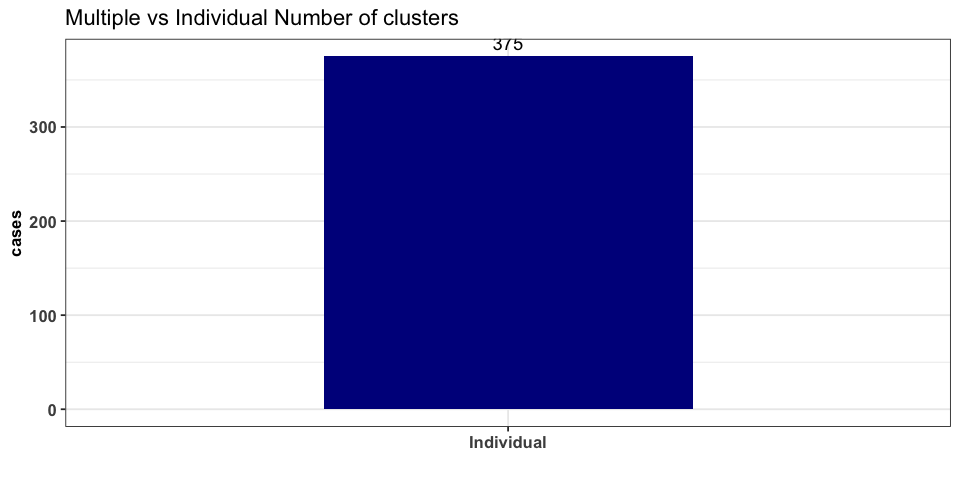

In [38]:
options(repr.plot.width=8, repr.plot.height=4)

data_cluster %>%
 group_by(cluster) %>%
 tally %>%
 ungroup %>%
 mutate(desc = ifelse(n == 1, 'Individual', 'Multiple')) %>%
 group_by(desc) %>%
 summarise(cases = n()) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Multiple vs Individual Number of clusters') +
 theme(legend.position = 'none',
       axis.text.x     = element_text(size = 10, face = 'bold'),
       axis.text.y     = element_text(size = 10, face = 'bold'),
       axis.title.x    = element_text(size = 10, face = 'bold'),
       axis.title.y    = element_text(size = 10, face = 'bold')) +
 geom_text(aes(x = desc, y = cases, label = cases), vjust = -0.5) +
 xlab('')

### Individual Clusters examples

Clusters of only 1 distribution

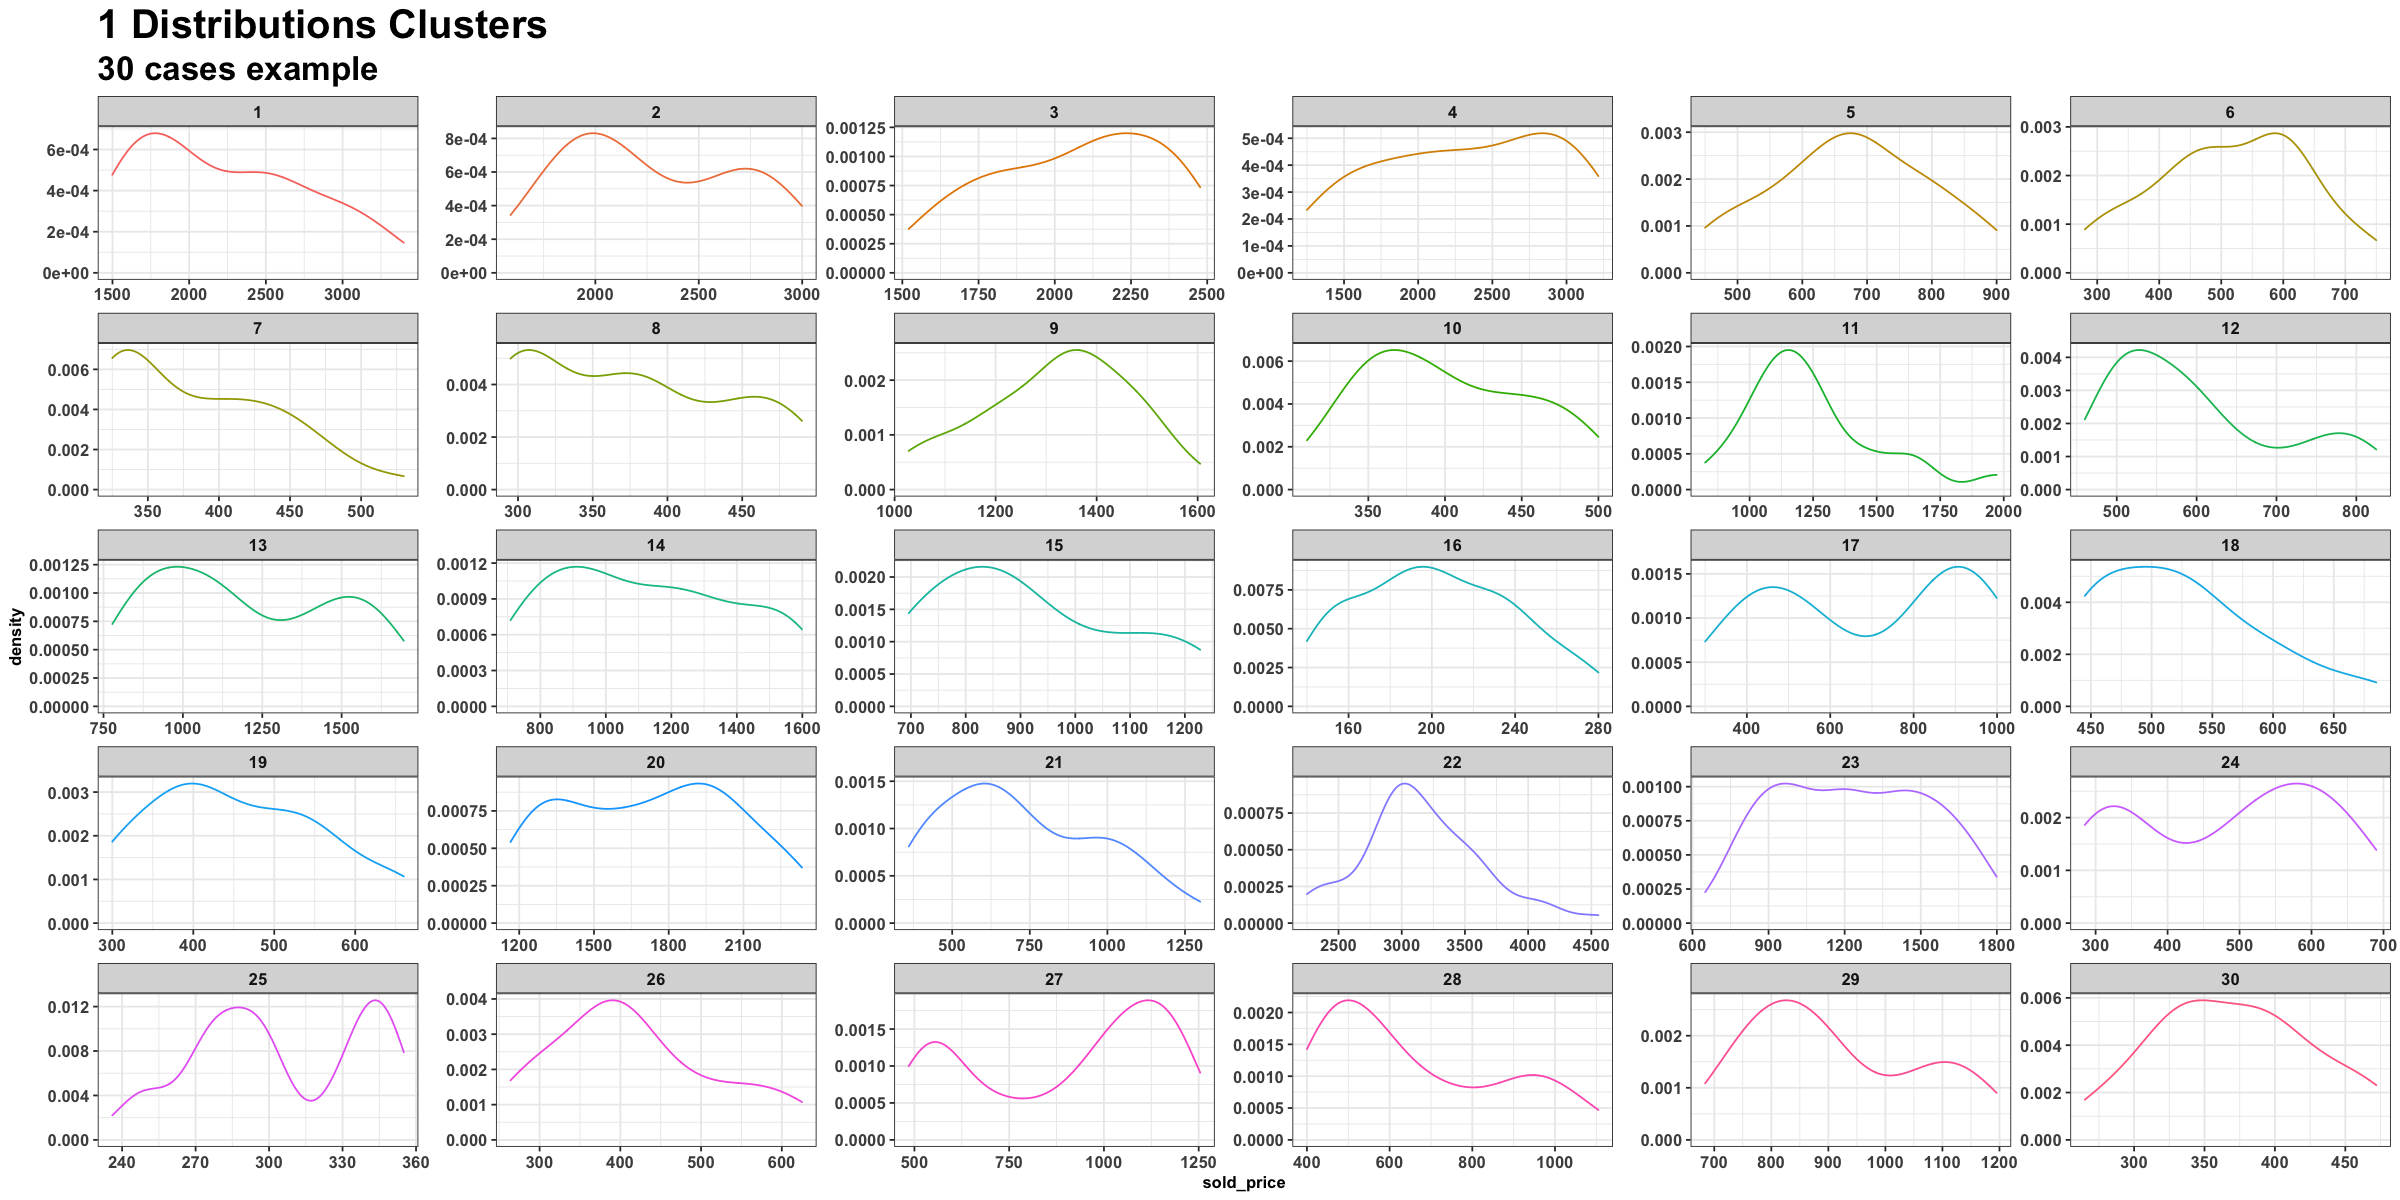

In [46]:
options(repr.plot.width=20, repr.plot.height=10)

data_cluster %>%
 group_by(cluster) %>%
 tally %>%
 filter(n == 1) %>%
 select(cluster) %>%
 head(30) %>%
 pull -> oneD_cluster

data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') %>%
 filter(cluster %in% oneD_cluster) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 ggtitle('1 Distributions Clusters', subtitle = '30 cases example') +
 facet_wrap(~cluster,scales = 'free') +
 theme(legend.position = 'none',
       axis.text.x     = element_text(size = 10, face = 'bold'),
       axis.text.y     = element_text(size = 10, face = 'bold'),
       axis.title.x    = element_text(size = 10, face = 'bold'),
       axis.title.y    = element_text(size = 10, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 10, face = 'bold'))



### Multiple Distribution Clusters examples

Clusters with more than 1 distribution

ERROR while rich displaying an object: Error: Faceting variables must have at least one value

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

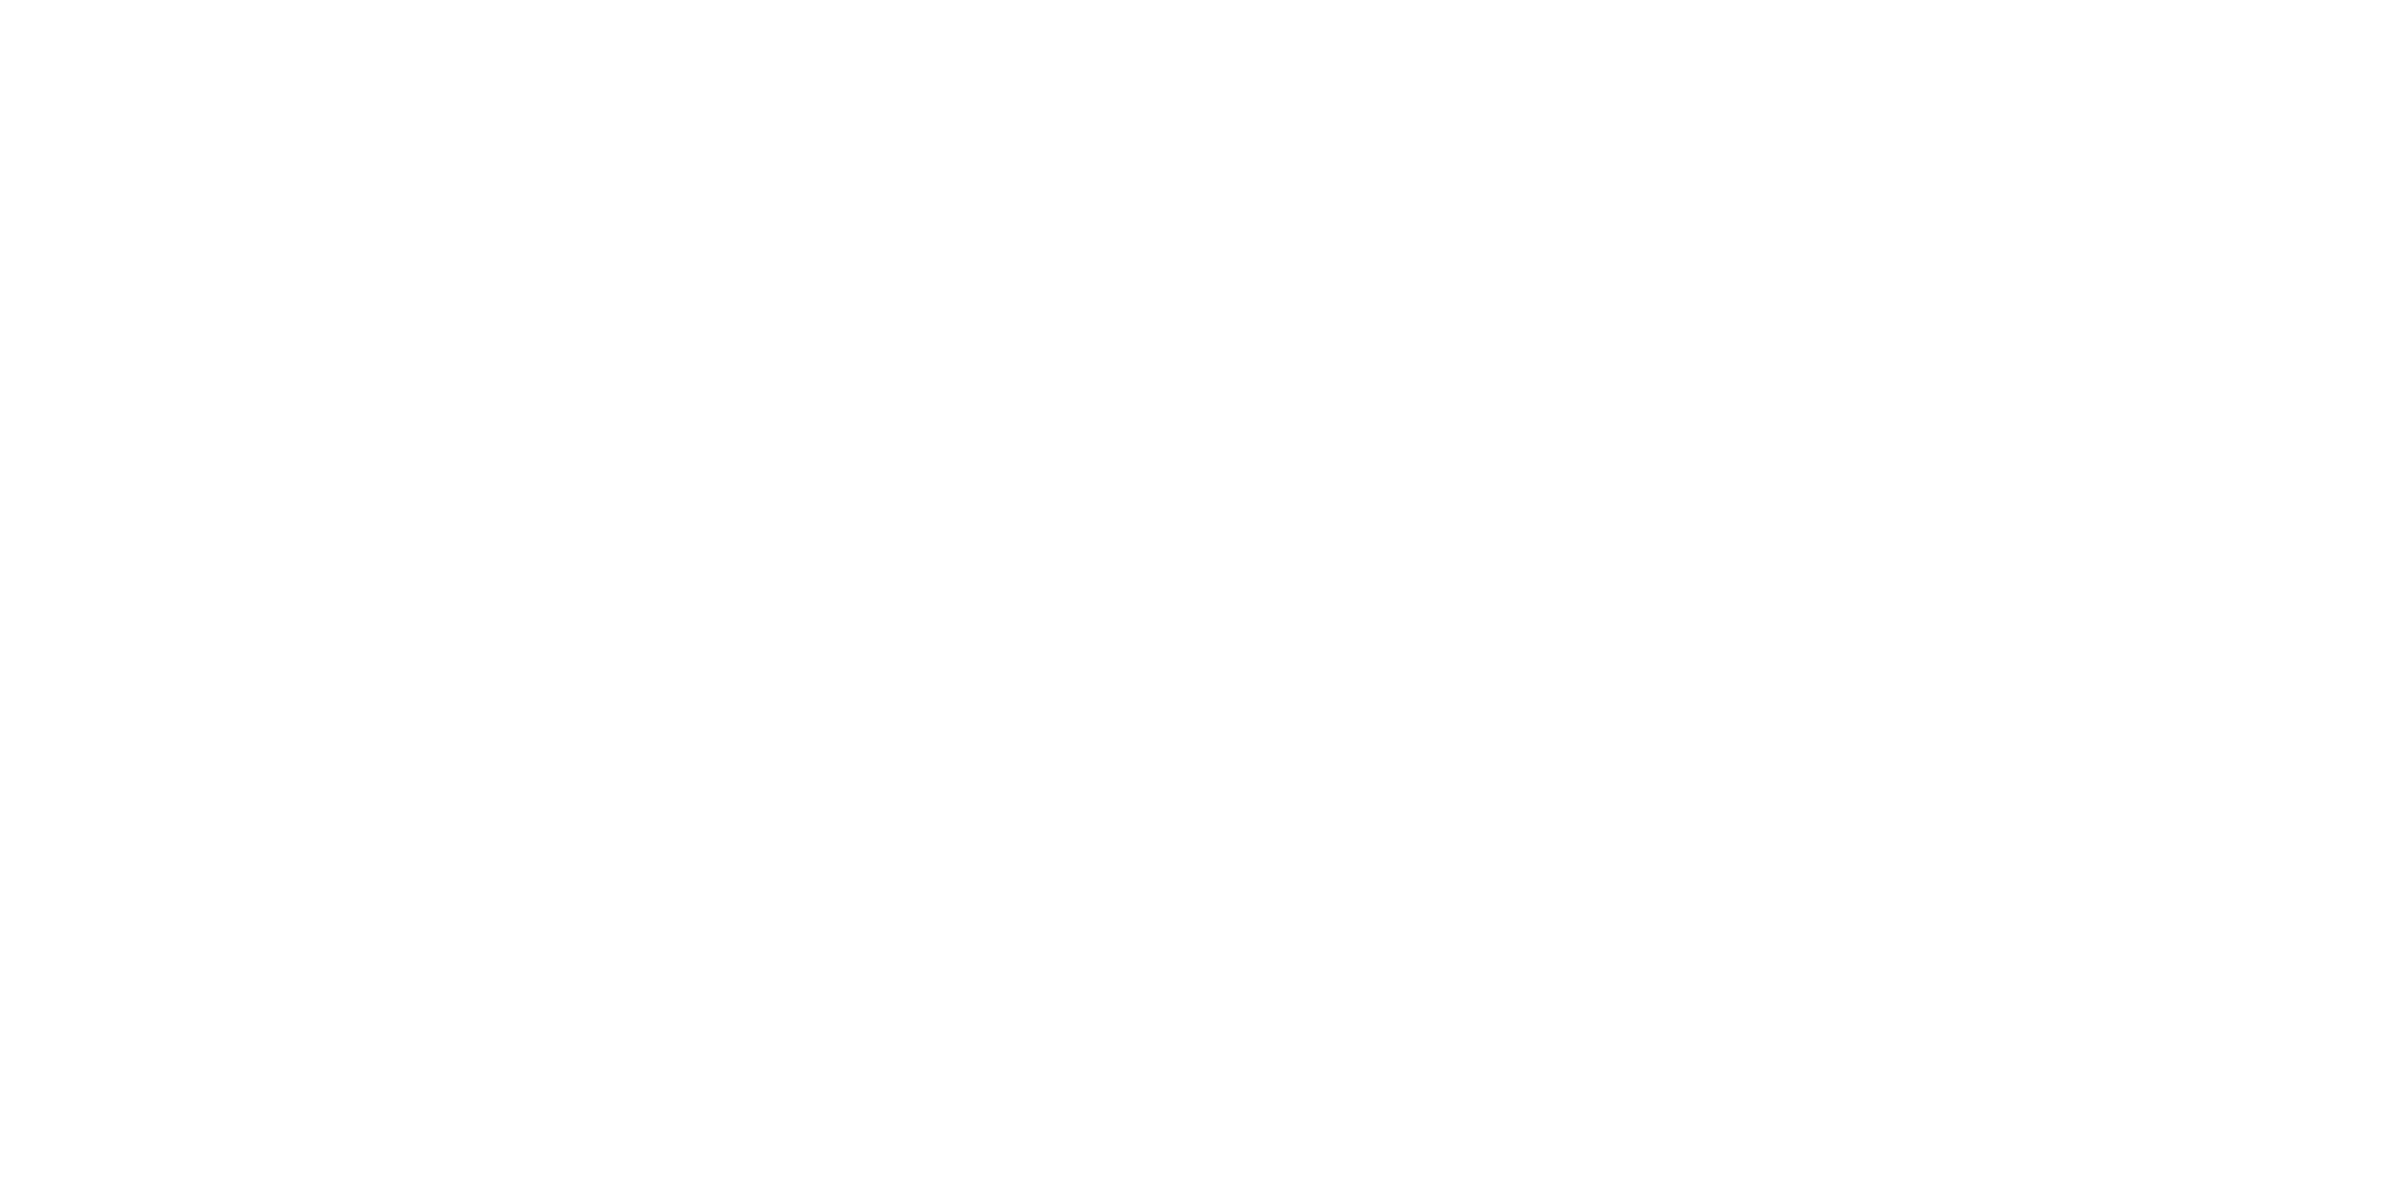

In [47]:
options(repr.plot.width=20, repr.plot.height=10)

data_cluster %>%
 group_by(cluster) %>%
 tally %>%
 filter(n > 1) %>%
 select(cluster) %>%
 head(40) %>%
 pull -> oneD_cluster

data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') %>%
 filter(cluster %in% oneD_cluster) %>%
 ggplot() +
 geom_density(aes(sold_price, colour = CategoryDesc)) +
 theme_bw() +
 ggtitle('Multiple Distributions Clusters', subtitle = '30 cases example') +
 facet_wrap(~cluster,scales = 'free') +
 theme(legend.position = 'none',
       axis.text.x     = element_text(size = 10, face = 'bold'),
       axis.text.y     = element_text(size = 10, face = 'bold'),
       axis.title.x    = element_text(size = 10, face = 'bold'),
       axis.title.y    = element_text(size = 10, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 10, face = 'bold'))

# Buckets

Create buckets with these rules:

 - If it is multimode, the buckets will be the modes
 - If it not multimode, and has skewness >= 0.10, and has a significant mode (>= 20%), then the bucket will be the mode

## Calculate modes

Calculate modes for each cluster

In [41]:
data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') %>%
 mutate(sold_price = round(sold_price)) %>%
 group_by(cluster,sold_price) %>%
 summarise(n = n()) %>%
 ungroup %>%
 group_by(cluster) %>%
 mutate(total = sum(n)) %>%
 ungroup %>%
 mutate(pct = n/total) %>%
 filter(pct >= 0.2) %>%
 group_by(cluster) %>%
 mutate(mode_ind = dense_rank(-pct),
        mode_ind = paste0('mode',mode_ind)) %>%
 rename('mode' = 'sold_price') %>%
 select(cluster,mode,mode_ind) %>%
 group_by(cluster) %>%
 mutate(num_modes = n()) %>%
 group_by(cluster) %>%
 mutate(num_modes = max(num_modes)) -> modes

head(modes,5)



`summarise()` regrouping output by 'cluster' (override with `.groups` argument)



cluster mode mode_ind num_modes
1 1       15   mode1    2        
2 1       20   mode2    2        
3 3       25   mode1    2        
4 3       40   mode2    2        
5 4       25   mode1    2

## Calculate Skewness

Calculate the Skewness for each distribution

In [42]:
data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') %>%
 group_by(cluster) %>%
 summarise(sk = skewness(sold_price)) -> sk_df

`summarise()` ungrouping output (override with `.groups` argument)



## Get buckets

Get buckets with the two filters 

In [43]:
sk_df %>%
 left_join(modes,by='cluster') %>%
 filter(abs(sk)>=0.1) %>%
 filter(!is.na(mode)) -> groups_buckets

#sk_df %>%
# left_join(modes,by='cluster') %>%
# filter((num_modes==1 | sk >= 0.05) | num_modes > 1) %>%
# filter(!is.na(mode)) -> groups_buckets

Add the Manufacturer to the clusters

In [44]:
data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') %>%
 distinct(cluster, CategoryDesc, CategoryDesc_original,Manufacturer) -> CD

groups_buckets %>%
 left_join(CD,by='cluster') %>%
 select(-sk) -> Manufacturer_Buckets

Add the number of distributions per cluster and the skewness

In [45]:
data_cluster %>%
 group_by(cluster) %>%
 summarise(num_dis = n()) -> num_dis

data %>%
 group_by(CategoryDesc) %>%
 summarise(cases = n()) -> num_cases

Manufacturer_Buckets %>%
 left_join(num_dis, by = 'cluster') %>%
 left_join(sk_df, by = 'cluster') %>%
 left_join(num_cases, by = 'CategoryDesc') -> Manufacturer_Buckets

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



# Bucket Examples

Examples for:
 - No bucket cluster
 - One bucket cluster
 - Two bucket cluster

In [46]:
data %>%
 left_join(data_cluster %>% select(CategoryDesc, cluster), by = 'CategoryDesc') -> data

## No bucket example

In [47]:
unique(Manufacturer_Buckets$cluster) %>% head(10)

[1]  1  4  5  8  9 10 12 15 17 18

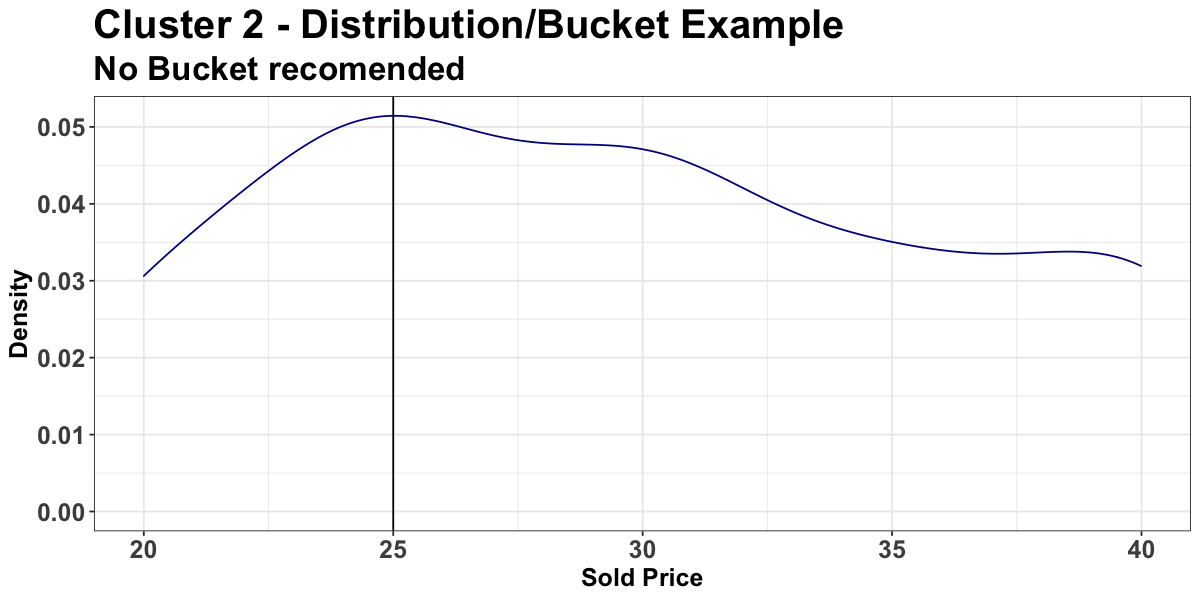

In [48]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 2) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 2 - Distribution/Bucket Example', subtitle = 'No Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 25) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

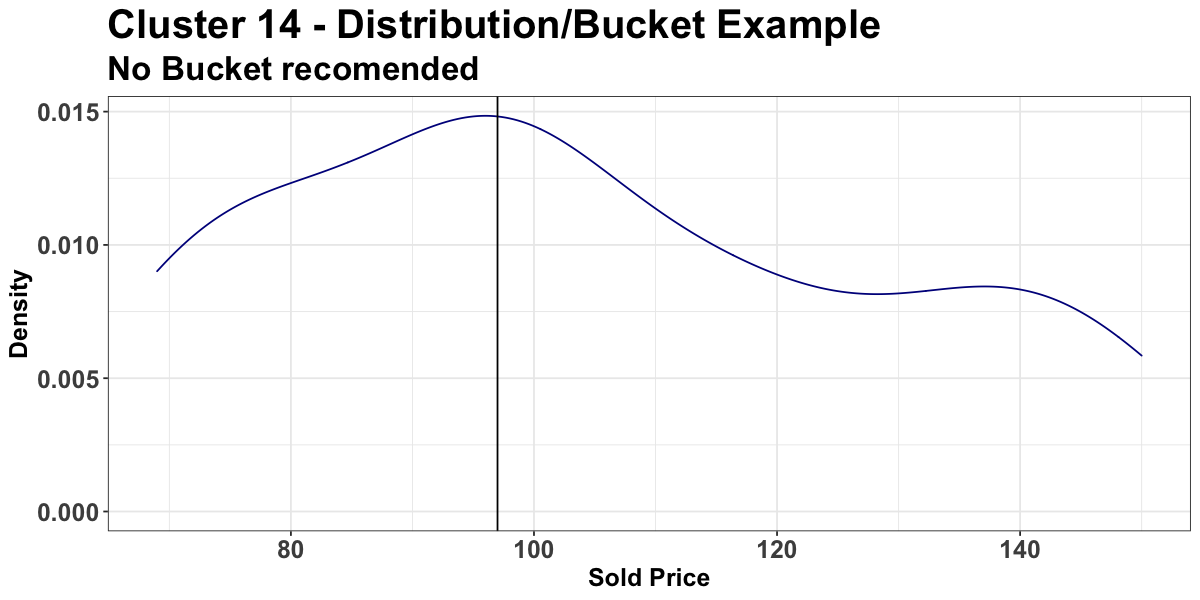

In [49]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 14) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 14 - Distribution/Bucket Example', subtitle = 'No Bucket recomended') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 97) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## One Distribution Cluster No Bucket Example

In [50]:
Manufacturer_Buckets %>%
 filter(num_modes == 1, num_dis == 1, cases <= 30) %>%
 head(2)

cluster mode mode_ind num_modes CategoryDesc          Manufacturer
1  9      20   mode1    1         adidas-Sports Jerseys adidas      
2 12      40   mode1    1         alpine-AM/FM/CD/MP3   alpine      
  CategoryDesc_original num_dis sk        cases
1 Sports Jerseys        1       1.3151288 20   
2 AM/FM/CD/MP3          1       0.3743392 29

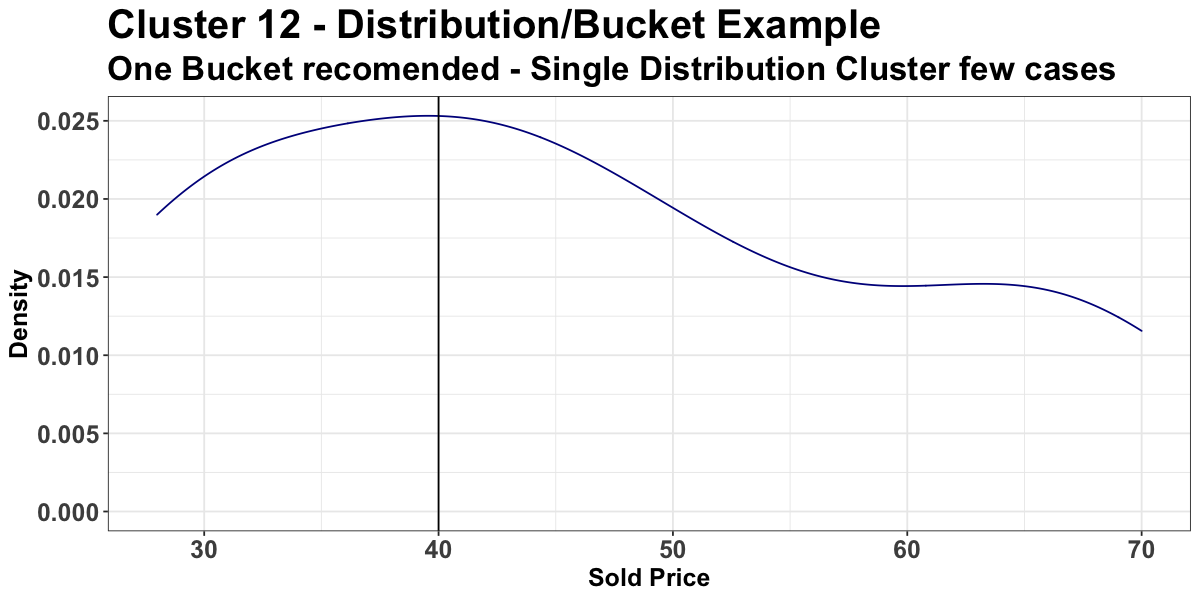

In [51]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 12) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 12 - Distribution/Bucket Example', subtitle = 'One Bucket recomended - Single Distribution Cluster few cases') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 40) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

In [52]:
Manufacturer_Buckets %>%
 filter(num_modes > 1, num_dis == 1, cases <= 25) %>%
 head(2)

cluster mode mode_ind num_modes CategoryDesc              Manufacturer
1 8       40   mode1    2         acoustic-Guitar Amplifier acoustic    
2 8       45   mode1    2         acoustic-Guitar Amplifier acoustic    
  CategoryDesc_original num_dis sk        cases
1 Guitar Amplifier      1       0.1066325 21   
2 Guitar Amplifier      1       0.1066325 21

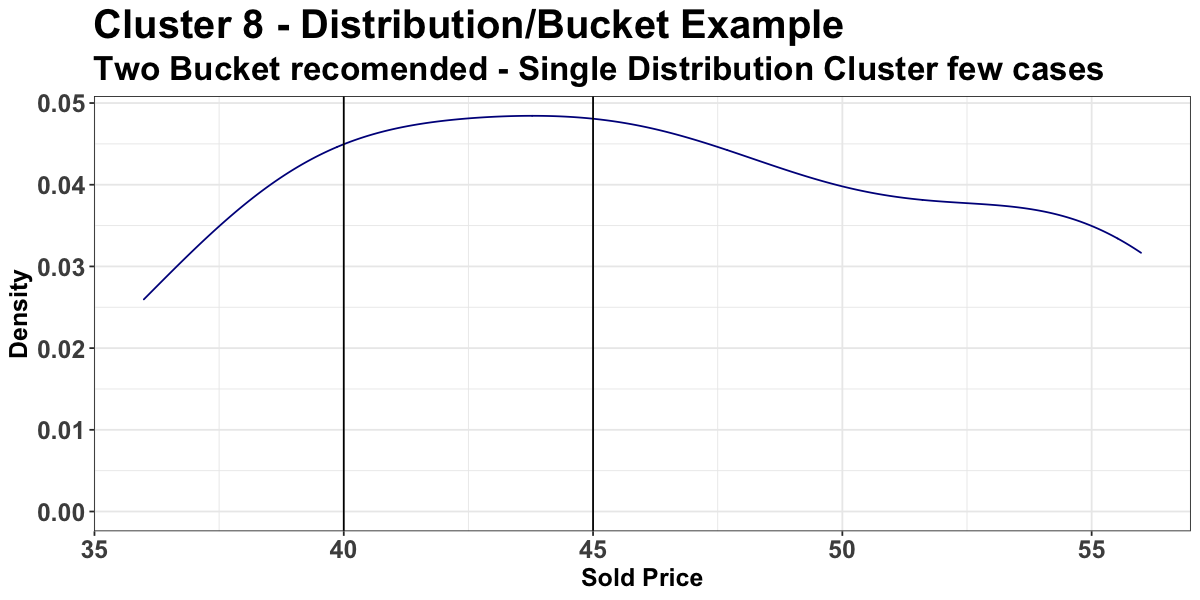

In [53]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 8) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 8 - Distribution/Bucket Example', subtitle = 'Two Bucket recomended - Single Distribution Cluster few cases') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 40) +
 geom_vline(xintercept = 45) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## One Bucket Example

In [54]:
Manufacturer_Buckets %>%
 filter(num_modes == 1, num_dis == 1) %>%
 head(2)

cluster mode mode_ind num_modes CategoryDesc          Manufacturer
1 5       20   mode1    1         acdelco-Jack Stands   acdelco     
2 9       20   mode1    1         adidas-Sports Jerseys adidas      
  CategoryDesc_original num_dis sk        cases
1 Jack Stands           1       0.5165236 55   
2 Sports Jerseys        1       1.3151288 20

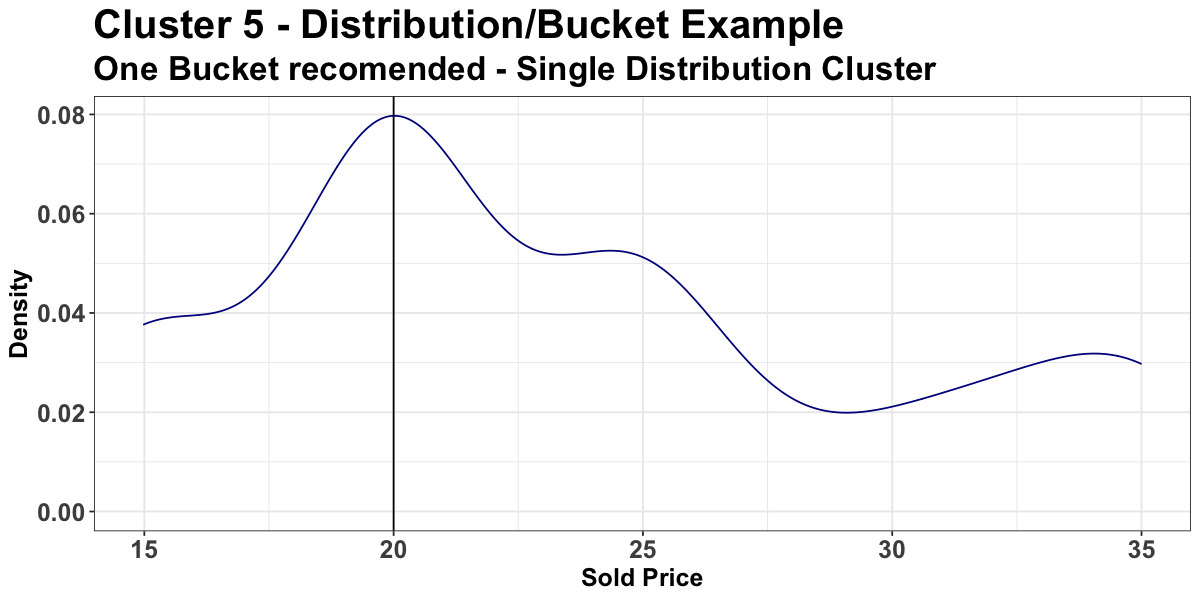

In [55]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 5) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 5 - Distribution/Bucket Example', subtitle = 'One Bucket recomended - Single Distribution Cluster') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 20) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

In [56]:
Manufacturer_Buckets %>%
 filter(num_modes == 1, num_dis > 1) %>%
 distinct(cluster,mode) %>%
 head(4)

cluster mode
1  22     10  
2  68     20  
3  69     15  
4 127     35

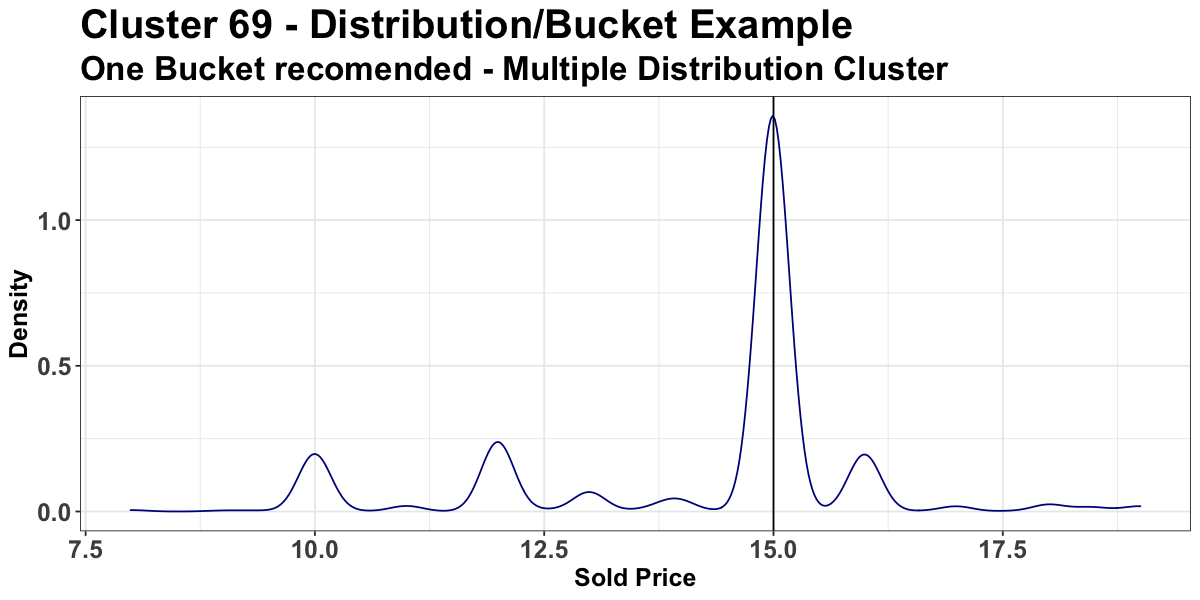

In [57]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 69) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 69 - Distribution/Bucket Example', subtitle = 'One Bucket recomended - Multiple Distribution Cluster') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 15) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

## Two Bucket Example

In [58]:
Manufacturer_Buckets %>%
 filter(num_modes == 2, num_dis == 1, cases >= 50, abs(sk) >= 0.5) %>%
 head(15)

cluster mode mode_ind num_modes CategoryDesc                        
1   33      80  mode2    2         apple-Media Streaming Players       
2   33     100  mode1    2         apple-Media Streaming Players       
3   58      50  mode1    2         bauer-Cordless Impact Drills        
4   58      55  mode2    2         bauer-Cordless Impact Drills        
5   98      15  mode1    2         blackweb-Portable Speakers          
6   98      20  mode2    2         blackweb-Portable Speakers          
7  165      40  mode1    2         centralpneumatic-Electric Compressor
8  165      45  mode2    2         centralpneumatic-Electric Compressor
9  259      30  mode1    2         dewalt-Corded Disc Sander           
10 259      35  mode2    2         dewalt-Corded Disc Sander           
11 410      40  mode2    2         guess-Regular Watch                 
12 410      45  mode1    2         guess-Regular Watch                 
13 422      40  mode2    2         hart-Cordless Combo Drills / Drivers
14 422      45  mode1    2         hart-Cordless Combo Drills / Drivers
15 485      35  mode1    2         hypertough-Electric Compressor      
   Manufacturer     CategoryDesc_original           num_dis sk         cases
1  apple            Media Streaming Players         1       -0.6847392  86  
2  apple            Media Streaming Players         1       -0.6847392  86  
3  bauer            Cordless Impact Drills          1        1.0112306  55  
4  bauer            Cordless Impact Drills          1        1.0112306  55  
5  blackweb         Portable Speakers               1        1.0975360 274  
6  blackweb         Portable Speakers               1        1.0975360 274  
7  centralpneumatic Electric Compressor             1        0.7890761 427  
8  centralpneumatic Electric Compressor             1        0.7890761 427  
9  dewalt           Corded Disc Sander              1        0.5000900  83  
10 dewalt           Corded Disc Sander              1        0.5000900  83  
11 guess            Regular Watch                   1       -0.7037870 129  
12 guess            Regular Watch                   1       -0.7037870 129  
13 hart             Cordless Combo Drills / Drivers 1        1.4425617 125  
14 hart             Cordless Combo Drills / Drivers 1        1.4425617 125  
15 hypertough       Electric Compressor             1       -0.7191230  60

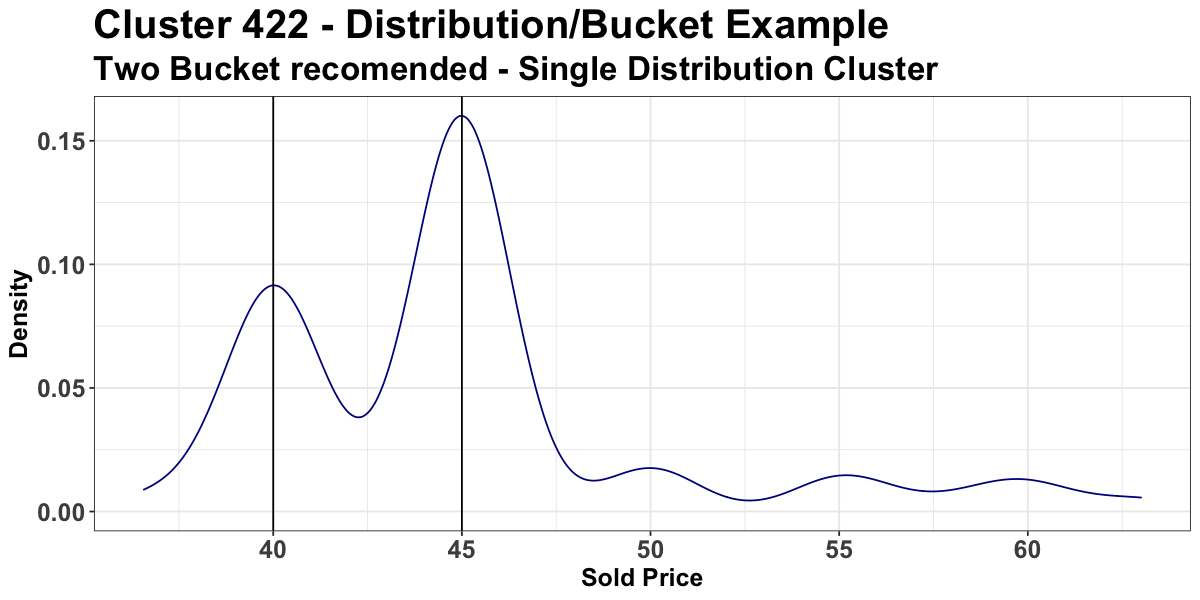

In [59]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 422) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 422 - Distribution/Bucket Example', subtitle = 'Two Bucket recomended - Single Distribution Cluster') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 40) +
 geom_vline(xintercept = 45) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

In [60]:
Manufacturer_Buckets %>%
 filter(num_modes > 1, num_dis > 1) %>%
 distinct(cluster,mode) %>%
 head(2)

cluster mode
1 1       15  
2 1       20

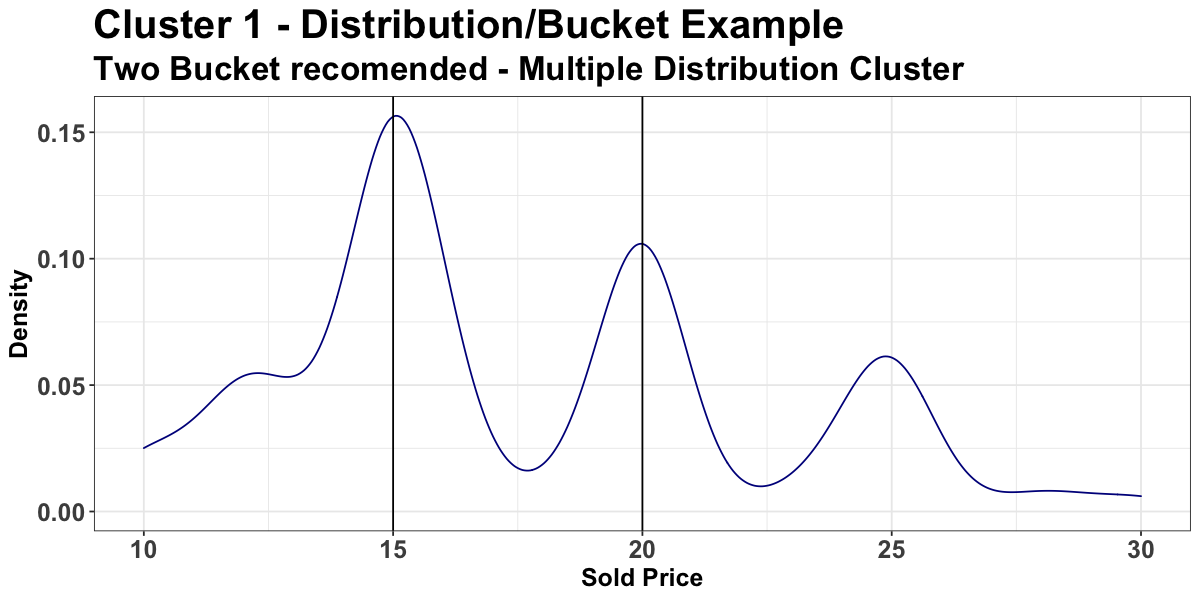

In [61]:
options(repr.plot.width=10, repr.plot.height=5)

data %>%
 filter(cluster == 1) %>%
 ggplot() +
 geom_density(aes(sold_price), colour = 'darkblue') +
 ggtitle('Cluster 1 - Distribution/Bucket Example', subtitle = 'Two Bucket recomended - Multiple Distribution Cluster') +
 theme_bw() +
 xlab('Sold Price') +
 ylab('Density') +
 geom_vline(xintercept = 15) +
 geom_vline(xintercept = 20) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Cleaned Buckets

As we saw in the examples, just keep 1 cluster buckets with distributions with at least 50 items sold

In [62]:
Manufacturer_Buckets %>%
 filter((num_dis > 1) | ((num_dis == 1) & (cases >= 40))) -> Manufacturer_Buckets

Write data

In [63]:
setwd('/Users/darias/Documents/Bucket_Pricing/Data_Out/')
write.csv(Manufacturer_Buckets, file = 'Buckets_Manufacturer_DBScan.csv', row.names = FALSE)

In [64]:
#Manufacturer_Buckets<-read_csv('/Users/darias/Documents/Bucket_Pricing/Data_Out/Buckets_Manufacturer_DBScan.csv')


In [65]:
unique(data$CategoryDesc) %>% length

[1] 1335

In [66]:
unique(Manufacturer_Buckets$CategoryDesc) %>% length

[1] 454

In [67]:
unique(Manufacturer_Buckets$cluster) %>% length

[1] 205

# Business Case - Sold Price

We will see the total sold amount of the Manufacturers with a bucket, using the real sold price and the one in the bucket

In [68]:
Manufacturer_Buckets %>%
 group_by(CategoryDesc) %>%
 summarise(bucket = mean(mode)) -> buc

`summarise()` ungrouping output (override with `.groups` argument)



In [69]:
data %>%
 filter(CategoryDesc %in% Manufacturer_Buckets$CategoryDesc) %>%
 left_join(buc, by = 'CategoryDesc') -> data_buc

In [70]:
real      <- sum(data_buc$sold_price)
estimated <- sum(data_buc$bucket)

print(paste0('The real amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real))))
print(paste0('The estimated amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated))))

[1] "The real amount earned for items with Manufacturers with bucket assigned is: $1,483,169"
[1] "The estimated amount earned for items with Manufacturers with bucket assigned is: $1,451,994"


Annualize numbers:

We know that the numbers above are from July2020 - Nov2020 (7 months).

If we suppose is a uniform distribution of earnings, we can multiply those numbers by 12/7

In [71]:
real_anual <- real*(12/7)
estimated_anual <- estimated*(12/7)

print(paste0('The real amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real_anual))))
print(paste0('The estimated amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated_anual))))

[1] "The real amount, anualized, earned for items with Manufacturers with bucket assigned is: $2,542,576"
[1] "The estimated amount, anualized, earned for items with Manufacturers with bucket assigned is: $2,489,133"


Plots

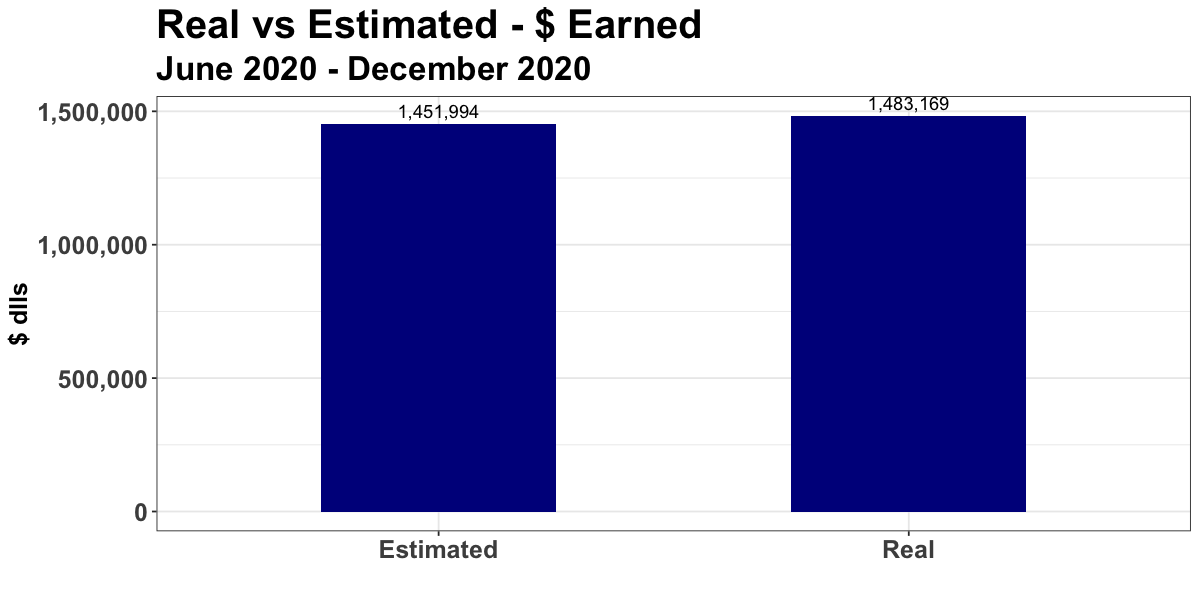

In [72]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real,estimated)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Earned', subtitle = 'June 2020 - December 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

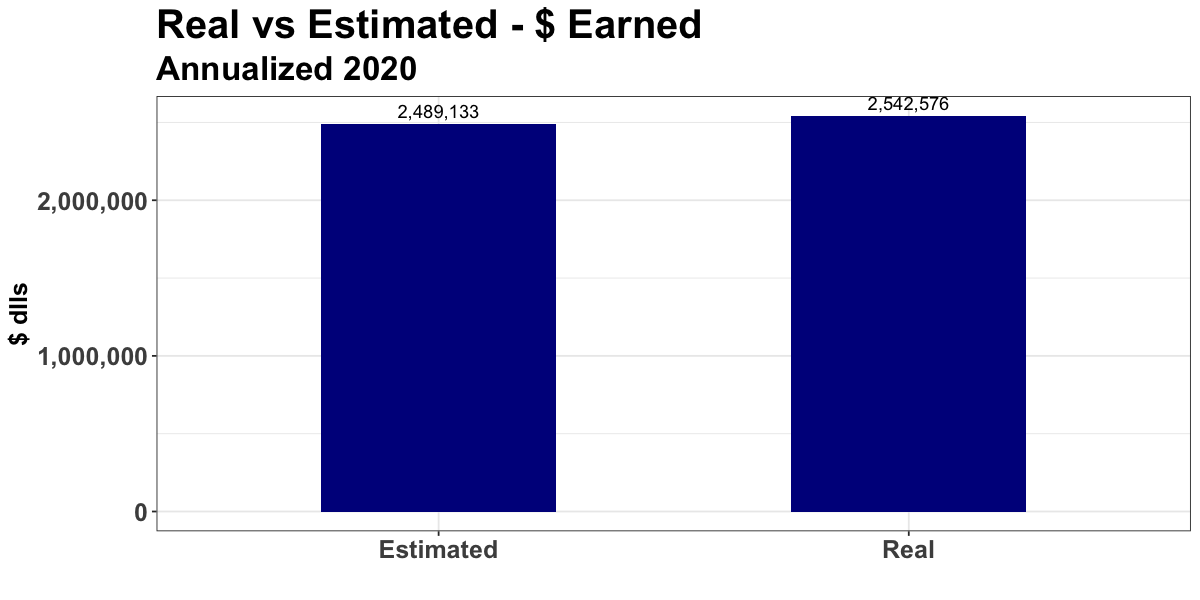

In [73]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real_anual,estimated_anual)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Earned', subtitle = 'Annualized 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Business Case - Loan Amoun

For this excercise, we will see the total of Loan Amount, using the real Loan Amount, and the estimated Loan Amount, using the buckets.

$$\text{Estimated Loan Amount}_{item} = Bucket_{item_{CategoryManu}}*\text{Real LTV}_{item}$$

In [74]:
data %>%
 left_join(buc, by = 'CategoryDesc') %>%
 mutate(Loan_amt_real = cost,
        Loan_amt_estimated = bucket*LTV) %>%
 filter(CategoryDesc %in% Manufacturer_Buckets$CategoryDesc) -> data_bc

In [75]:
real      <- sum(data_bc$Loan_amt_real)
estimated <- sum(data_bc$Loan_amt_estimated)

print(paste0('The real Total Loan Amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real))))
print(paste0('The estimated Total Loan amount earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated))))

[1] "The real Total Loan Amount earned for items with Manufacturers with bucket assigned is: $682,790"
[1] "The estimated Total Loan amount earned for items with Manufacturers with bucket assigned is: $670,219"


Annualize numbers:

We know that the numbers above are from June2020 - Dec2020 (7 months).

If we suppose is a uniform distribution of earnings, we can multiply those numbers by 12/7

In [76]:
real_anual <- real*(12/7)
estimated_anual <- estimated*(12/7)

print(paste0('The real Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(real_anual))))
print(paste0('The estimated Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $', scales::comma(round(estimated_anual))))

[1] "The real Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $1,170,498"
[1] "The estimated Total Loan Amount, anualized, earned for items with Manufacturers with bucket assigned is: $1,148,946"


Plots

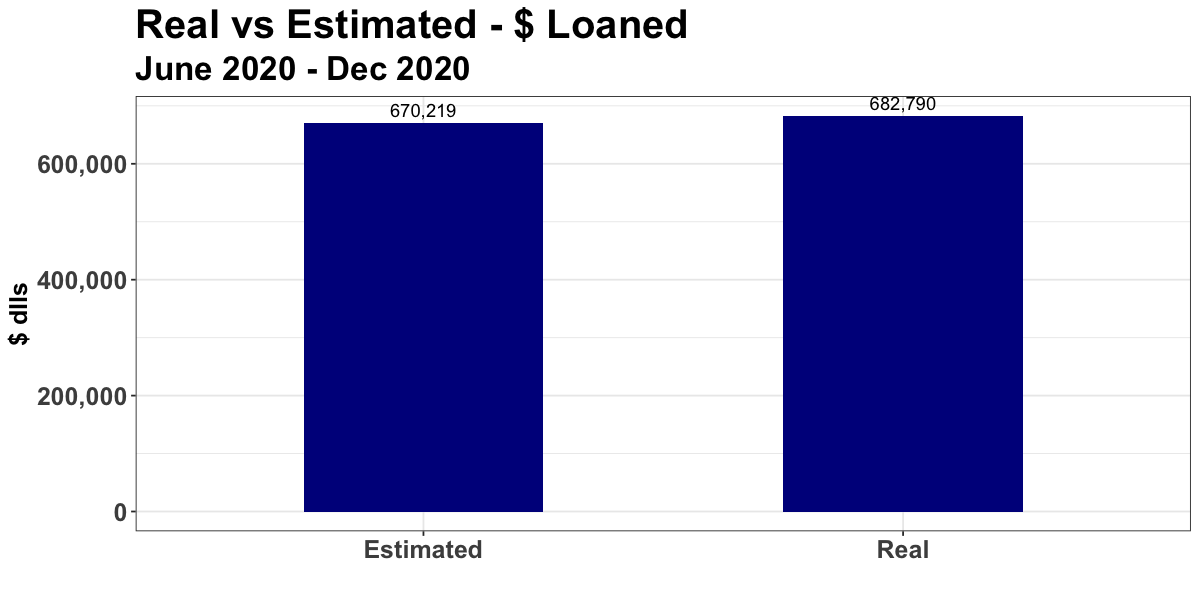

In [77]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real,estimated)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Loaned', subtitle = 'June 2020 - Dec 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

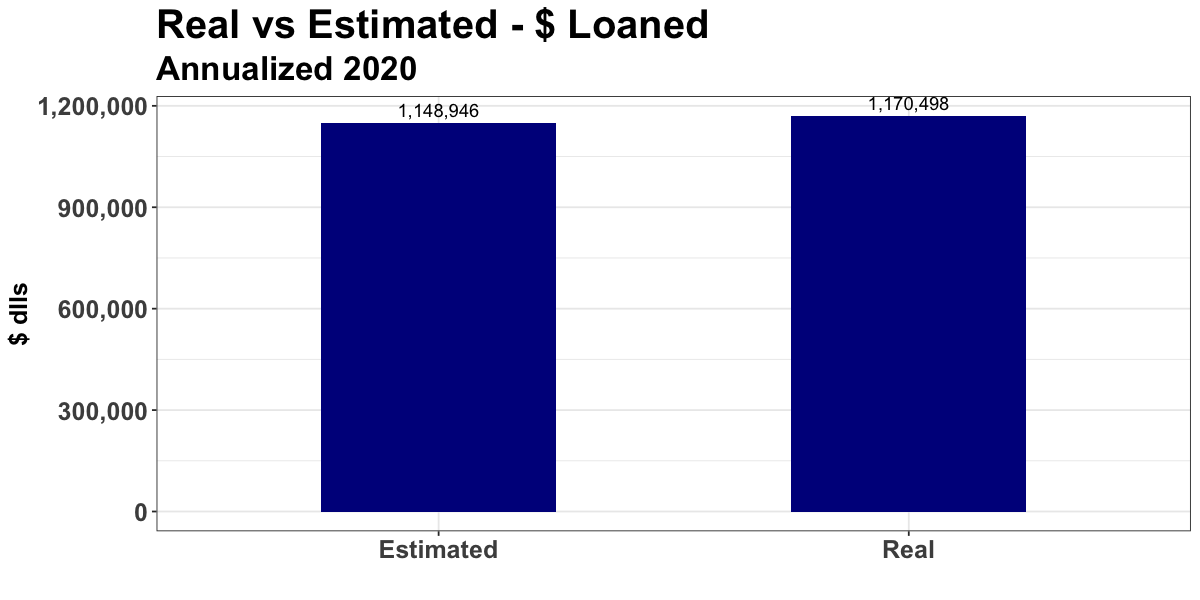

In [78]:
options(repr.plot.width=10, repr.plot.height=5)

data.frame(desc = c('Real', 'Estimated'),
           total = c(real_anual,estimated_anual)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = total), fill = 'darkblue', width = 0.5) +
 theme_bw() +
 ggtitle('Real vs Estimated - $ Loaned', subtitle = 'Annualized 2020') +
 scale_y_continuous(labels = scales::comma) +
 xlab('') +
 ylab('$ dlls') +
 geom_text(aes(x = desc, y = total, label = scales::comma(total)), vjust = -0.5) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'))

# Business Cases - % Items Priced

Get all items loaned/purchased in 2020, and get the percentage of dollars with items with a price assigned with the bucket.

This dropping the big categories

In [79]:
data2020 <- read_csv('/Users/darias/Documents/Bucket_Pricing/Data/LoansPurchase_Made_US2020.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  primary_relation = col_double(),
  FiscalYear = col_double(),
  ItemID = col_double(),
  cost = col_double(),
  item_categorization = col_double(),
  Inventory_Days = col_double()
)

See spec(...) for full column specifications.



Drop big categories

In [80]:
x <- c(
'Video Game Console',
'Laptop',
'LED',
'Digital OLED TVs',
'LCD',
'Tablet',
'Smart Phones',
'Cellular Telephone',
'null',
'Shoes',
'NULL')

data2020 %>%
 filter(!(CategoryDesc %in% x)) -> data2020

Manufacturer in lowercase, without spaces

In [81]:
data2020 %>%
 mutate(Manufacturer = tolower(Manufacturer),
        Manufacturer = gsub(' ', '', Manufacturer)) -> data2020

Paste the Manufacturer and the CategoryDesc to create the Categories

In [82]:
data2020 %>%
 mutate(CategoryDesc_original = CategoryDesc,
        CategoryDesc          = paste0(Manufacturer,'-',CategoryDesc)) -> data2020

Add to the data an indicator, to see if the item has a bucket assigned

In [83]:
nrow(data2020)

[1] 1951082

In [84]:
un <- unique(Manufacturer_Buckets$CategoryDesc)

data2020 %>%
 mutate(ind_bucket = ifelse(CategoryDesc %in% un, 'Bucket', 'No Bucket')) -> data2020

## Items with buckets - Cases

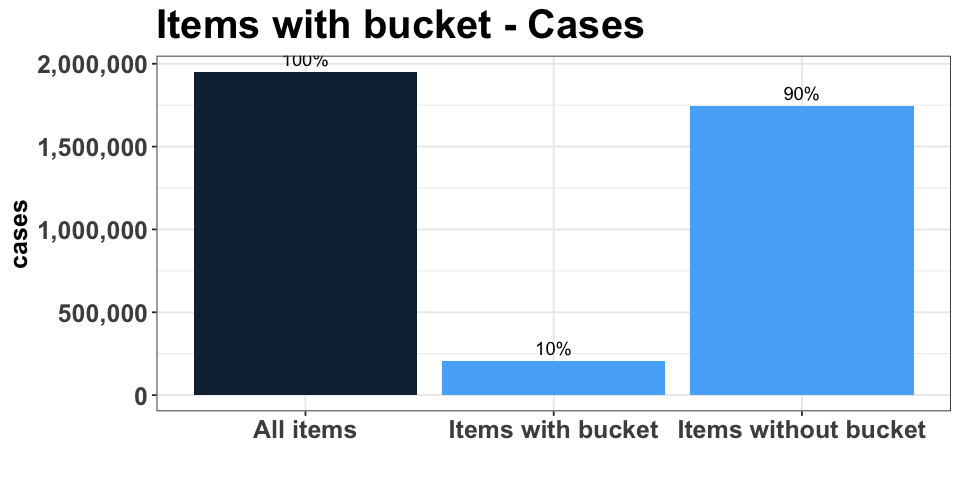

In [85]:
options(repr.plot.width=8, repr.plot.height=4)

total_items         <- nrow(data2020)
items_no_bucket     <- data2020 %>% filter(ind_bucket != 'Bucket') %>% nrow
items_bucket        <- data2020 %>% filter(ind_bucket == 'Bucket') %>% nrow
pct_items           <- 1
pct_items_no_bucket <- items_no_bucket/total_items
pct_items_bucket    <- items_bucket/total_items

data.frame(desc = c('All items','Items without bucket','Items with bucket'),
           cases = c(total_items,items_no_bucket,items_bucket),
           pct   = c(pct_items,pct_items_no_bucket,pct_items_bucket),
           colo  = c(1,2,2)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases, fill = colo)) +
 theme_bw() +
 ggtitle('Items with bucket - Cases') +
 geom_text(aes(x = desc, y = cases, label = scales::percent(pct)), vjust = -0.5) +
 scale_y_continuous(labels = scales::comma) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'),
       legend.position = 'none') +
 xlab('')

## Items with Buckets - Dlls Loan

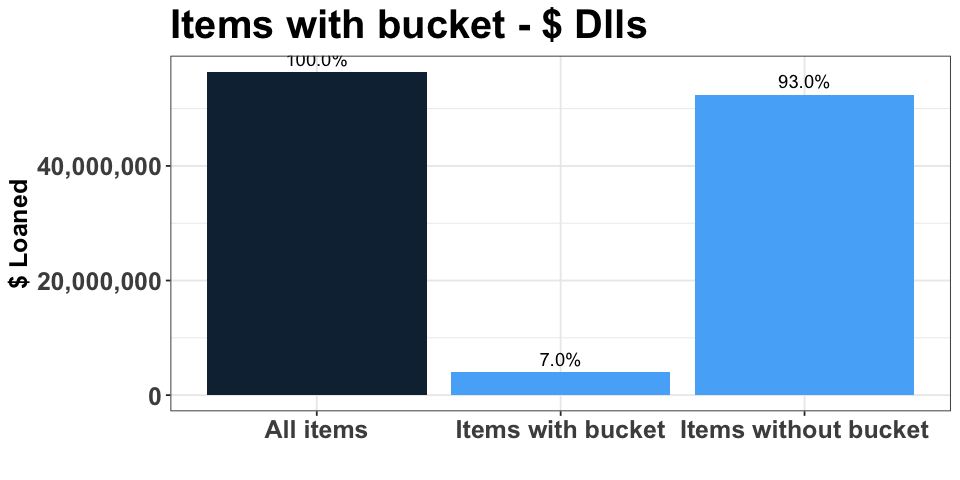

In [86]:
options(repr.plot.width=8, repr.plot.height=4)

total_items         <- sum(data2020$cost)
items_no_bucket     <- data2020 %>% filter(ind_bucket != 'Bucket') %>% select(cost) %>% pull %>% sum
items_bucket        <- data2020 %>% filter(ind_bucket == 'Bucket') %>% select(cost) %>% pull %>% sum
pct_items           <- 1
pct_items_no_bucket <- items_no_bucket/total_items
pct_items_bucket    <- items_bucket/total_items

data.frame(desc = c('All items','Items without bucket','Items with bucket'),
           cases = c(total_items,items_no_bucket,items_bucket),
           pct   = c(pct_items,pct_items_no_bucket,pct_items_bucket),
           colo  = c(1,2,2)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = cases, fill = colo)) +
 theme_bw() +
 ggtitle('Items with bucket - $ Dlls') +
 geom_text(aes(x = desc, y = cases, label = scales::percent(pct)), vjust = -0.5) +
 scale_y_continuous(labels = scales::comma) +
 theme(axis.text.x     = element_text(size = 15, face = 'bold'),
       axis.text.y     = element_text(size = 15, face = 'bold'),
       axis.title.x    = element_text(size = 15, face = 'bold'),
       axis.title.y    = element_text(size = 15, face = 'bold'),
       title           = element_text(size = 20, face = 'bold'),
       strip.text.x    = element_text(size = 18, face = 'bold'),
       legend.position = 'none') +
 ylab('$ Loaned') +
 xlab('')